# Bug triage with Deep Learning

In [1]:
from __future__ import print_function, division

In [13]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib inline

In [14]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

## Auxiliary methods

### Plot ROC/AUC curve

### Plot validation accuracy and loss

In [144]:
def validation_accuracy_loss(history):
  acc=history.history['acc']
  val_acc=history.history['val_acc']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  plt.plot(acc, label='acc')
  plt.plot(val_acc, label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
import sklearn.metrics

def curve_roc_auc(model, x, y_valid):
  y_hat = model.predict(x)
  pct_auc = roc_auc_score(y_valid, y_hat) * 100
  #print('ROC/AUC: {:0.2f}'.format(pct_auc))

  fpr, tpr, _ = sklearn.metrics.roc_curve(y_valid, y_hat)
  roc_auc = sklearn.metrics.auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de Falsos Positivos')
  plt.ylabel('Taxa de Verdadeiros Positivos')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()

In [23]:
def show_model_output(valid_a, valid_b, valid_sim, model, nb_examples = 3):
    #pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = model.predict([valid_a, valid_b])
#     pred_sim = [1,1,1,1,1,1]
    for b_a, b_b, sim, pred in zip(valid_a, valid_b, valid_sim, pred_sim):
        key_a = ','.join(b_a.astype(str))
        key_b = ','.join(b_b.astype(str))
        print(sentence_dict[key_a])
        print(sentence_dict[key_b])
        print("similar=" + str(sim))
        print("prediction=" + str(pred[0]))
        print("########################")
    return valid_a, valid_b, valid_sim

In [52]:
import os
import _pickle as pickle

def load_model(name):
  m_dir = os.path.join(DIR, 'modelos')
  # load json and create model
  json_file = open(os.path.join(m_dir, "model_{}.json".format(name)), 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(os.path.join(m_dir, "model_{}.h5".format(name)))
  print("Loaded model from disk")
  return loaded_model

def save_model(model, name):
  m_dir = os.path.join(DIR, 'modelos')
  if not os.path.exists(m_dir):
    os.mkdir(m_dir)
  # serialize model to JSON
  model_json = model.to_json()
  with open(os.path.join(m_dir, "model_{}.json".format(name)), 'w') as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(os.path.join(m_dir, "model_{}.h5".format(name)))
  print("Saved model to disk")

def save_result(h, name):
  r_dir = os.path.join(DIR, 'resultados')
  if not os.path.exists(r_dir):
    os.mkdir(r_dir)
  with open(os.path.join(r_dir, name + '.pkl'), 'wb') as f:
     pickle.dump(h, f)
      
def load_result(name):
  with open(os.path.join(DIR, 'resultados', name + '.pkl'), 'r') as f:
     return pickle.load(f)

In [265]:
from sklearn.manifold import TSNE

def create_features(x_test_features):
  tsne_obj = TSNE(n_components=2,
                           init='pca',
                           random_state=101,
                           method='barnes_hut',
                           n_iter=500,
                           verbose=0)
  tsne_features = tsne_obj.fit_transform(x_test_features)
  return tsne_features

In [253]:
def decode_to_categorical(datum):
    return np.argmax(datum)
  

def plot_2d(test_labels, tsne_features):
  obj_categories = ['duplicate', 'non-duplicate']
  groups = [1, 0]
  colors = plt.cm.rainbow(np.linspace(0, 1, 2))
  plt.figure(figsize=(10, 10))

  # test_labels = test_bitmap_labels
  #test_labels = np.array([ decode_to_categorical(test_labels[i]) for i in range(test_labels.shape[0]) ])

  for c_group, c_color, c_label in zip(groups, colors, obj_categories):
      plt.scatter(tsne_features[np.where(test_labels == c_group), 0],
                  tsne_features[np.where(test_labels == c_group), 1],
                  marker='o',
                  color=c_color,
                  linewidth='1',
                  alpha=0.8,
                  label=c_label)
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.title('t-SNE on Testing Samples')
  plt.legend(loc='best')
  plt.savefig('clothes-dist.png')
  plt.show(block=False)

In [262]:
def display_embed_space(similarity_model, layer, batch_size):
    valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = batch_iterator(bug_dir, batch_size, 1)
    model  = similarity_model.get_layer(layer)
    model_final = Model(inputs=similarity_model.input, outputs=model.output)
    x_test_features = model_final.predict([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
                 valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], verbose = False, batch_size=batch_size)

    tsne_features = create_features(x_test_features)

    plot_2d(valid_sim, tsne_features)

## Dataset bugs

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

### Parse bugs preproprecessed

In [15]:
DIR = ''

In [16]:
df_train_pair = pd.read_csv('train_mozilla_firefox.csv')

In [17]:
bug_ids = []
with open(os.path.join(DIR, 'bug_ids.txt'), 'r') as f:
    for row in f:
        bug_ids.append(int(row))

## Configurações Globais

In [18]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 100 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Dicionário de títulos e descrições

In [19]:
%%time

import pickle as pickle

def padding_embed(max_char, field, bug):
    n = len(bug[field])
    if (max_char - n) > 0: # desc or title
        embed = np.empty(max_char - n)
        embed.fill(0)
        embed = np.concatenate([embed, bug[field]], axis=-1)
        embed = embed.astype(int)
    else:
        embed = np.array(bug[field][:max_char])
    return embed

sentence_dict = {}
corpus = []

for bug_id in tqdm(bug_ids):
    bug = pickle.load(open(os.path.join('bugs', '{}.pkl'.format(bug_id)), 'rb'))
#     print(str(bug['title_word']))
    title = padding_embed(MAX_SEQUENCE_LENGTH_T, 'title_word', bug)
    desc = padding_embed(MAX_SEQUENCE_LENGTH_D, 'description_word', bug)
    #print(len(title), len(desc))
    #print(",".join(title.astype(str)))
    sentence_dict[",".join(title.astype(str))] = bug['title']
    sentence_dict[",".join(desc.astype(str))] = bug['description']
    corpus.append(bug['title'])
    corpus.append(bug['description'])
#     break

100%|███████████████████████████████████| 92651/92651 [07:10<00:00, 271.63it/s]


Wall time: 7min 10s


In [20]:
len(sentence_dict)

182137

## Geração de batches

### Generating tiple of batches

In [231]:
%%time

import random
import _pickle as pickle
import numpy as np
import os

train_data, bug_ids, dup_sets = None, None, None

def get_neg_bug(invalid_bugs, bug_ids):
  neg_bug = random.choice(bug_ids)
  while neg_bug in invalid_bugs:
    neg_bug = random.choice(bug_ids)
  return neg_bug

def read_train_data(data):
  data_pairs = []
  data_dup_sets = {}
  print('Reading train data')
  with open(os.path.join(data, 'train.txt'), 'r') as f:
    for line in f:
      bug1, bug2 = line.strip().split()
      data_pairs.append([int(bug1), int(bug2)])
      if int(bug1) not in data_dup_sets.keys():
        data_dup_sets[int(bug1)] = set()
      data_dup_sets[int(bug1)].add(int(bug2))
  return data_pairs, data_dup_sets

def read_bug_ids(data):
  bug_ids = []
  print('Reading bug ids')
  with open(os.path.join(data, 'bug_ids.txt'), 'r') as f:
    for line in f:
      bug_ids.append(int(line.strip()))
  return bug_ids

# data - path
def prepare_dataset(data):
  global train_data
  global dup_sets
  global bug_ids
  if not train_data:
    train_data, dup_sets = read_train_data(data)
    #print(len(train_data))
  if not bug_ids:
    bug_ids = read_bug_ids(data)

def siam_gen(data, batch_size, n_neg):
    while True:
        input_sample, input_pos, input_neg, sim = batch_iterator(data, batch_size, n_neg)
        yield ({ 'title_in' : input_sample['title'], 'title_pos': input_pos['title'], 'title_neg' : input_neg['title'],
        'desc_in' : input_sample['description'], 'desc_pos' : input_pos['description'], 'desc_neg' : input_neg['description'] }, None)

bug_dir = os.path.join(DIR)
prepare_dataset(bug_dir)

Reading train data
Reading bug ids
Wall time: 3.38 s


In [292]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

def siam_gen_classification(data, batch_size, n_neg):
    while True:
        input_sample, input_pos, input_neg, sim = batch_iterator(data, batch_size, n_neg)
        sim = encoder.fit_transform(sim)
        sim = to_categorical(sim)
        yield ({ 'title_in' : input_sample['title'], 'title_pos': input_pos['title'], 'title_neg' : input_neg['title'],
        'desc_in' : input_sample['description'], 'desc_pos' : input_pos['description'], 'desc_neg' : input_neg['description'] }, sim)

In [232]:
def read_batch_bugs(batch_bugs, data):
  global bug_set
  desc_word = []
  short_desc_word = []
  for bug_id in batch_bugs:
    #bug = pickle.load(open(os.path.join(data, 'bugs', '{}.pkl'.format(bug_id)), 'rb'))
    bug = bug_set[bug_id]
    desc_word.append(bug['description_word'])
    short_desc_word.append(bug['title_word'])
    
  desc_word = np.array(desc_word)
  short_desc_word = np.array(short_desc_word)
  batch_bugs = dict()
  batch_bugs['desc'] = (desc_word)
  batch_bugs['title'] = (short_desc_word)

  return batch_bugs

def data_padding_bug(seq, max_seq_length):
    seq = seq[:max_seq_length]
    padding = max_seq_length - len(seq)
    if padding > 0:
        embed = np.empty(padding)
        embed.fill(0)
        return np.concatenate([embed, seq], -1).astype(int)
    else:
        return np.array(seq).astype(int)

def data_padding(data, max_seq_length):
  padded_data = np.zeros(shape=[len(data), max_seq_length])
  for i, seq in enumerate(data):
    seq = seq[:max_seq_length]
    padding_end = max_seq_length - len(seq)
    #print(seq)
    embed = np.empty(padding_end)
    embed.fill(0)
    padded_data[i] = np.concatenate([embed, seq], -1)
  return padded_data.astype(np.int)

In [233]:
from datetime import datetime

# data - path
# batch_size - 128
# n_neg - 1
def batch_iterator(data, batch_size, n_neg):
    global train_data
    global dup_sets
    global bug_ids
    global bug_set

    random.shuffle(train_data)
    num_batches = int(len(train_data) / batch_size)
    if len(data) % batch_size > 0:
        num_batches += 1
    #print(num_batches, batch_size)
    # loop = tqdm(range(num_batches))
    # loop.set_description('Training')

    batch_input, batch_pos, batch_neg = {'title' : [], 'desc' : []}, {'title' : [], 'desc' : []}, {'title' : [], 'desc' : []}

    n_train = len(train_data)

    batch_triplets = []
    
    for offset in range(batch_size):
        #d_start = datetime.now()
        #print("Offset", offset)
        neg_bug = get_neg_bug(dup_sets[train_data[offset][0]], bug_ids)
        #d_end = datetime.now()
        #print("Time", (d_end - d_start).microseconds)
        anchor, pos, neg = train_data[offset][0], train_data[offset][1], neg_bug
        bug_anchor = bug_set[anchor]
        bug_pos = bug_set[pos]
        bug_neg = bug_set[neg]
        batch_input['title'].append(bug_anchor['title_word'])
        batch_input['desc'].append(bug_anchor['description_word'])
        batch_pos['title'].append(bug_pos['title_word'])
        batch_pos['desc'].append(bug_pos['description_word'])
        batch_neg['title'].append(bug_neg['title_word'])
        batch_neg['desc'].append(bug_neg['description_word'])
        batch_triplets.append([train_data[offset][0], train_data[offset][1], neg_bug])

    batch_input['title'] = np.array(batch_input['title'])
    batch_input['desc'] = np.array(batch_input['desc'])
    batch_pos['title'] = np.array(batch_pos['title'])
    batch_pos['desc'] = np.array(batch_pos['desc'])
    batch_neg['title'] = np.array(batch_neg['title'])
    batch_neg['desc'] = np.array(batch_neg['desc'])

    n_half = batch_size // 2
    if n_half > 0:
        pos = np.full((1, n_half), 1)
        neg = np.full((1, n_half), 0)
        sim = np.concatenate([pos, neg], -1)[0]
    else:
        sim = np.array([np.random.choice([1, 0])])

    input_sample, input_pos, input_neg = {}, {}, {}

    input_sample = { 'title' : batch_input['title'], 'description' : batch_input['desc'] }
    input_pos = { 'title' : batch_pos['title'], 'description' : batch_pos['desc'] }
    input_neg = { 'title' : batch_neg['title'], 'description' : batch_neg['desc'] }

    return input_sample, input_pos, input_neg, sim #sim 

In [28]:
bug_set = {}

loop = tqdm(total=len(bug_ids))

for bug_id in bug_ids:
    bug_set[bug_id] = pickle.load(open(os.path.join(bug_dir, 'bugs', '{}.pkl'.format(bug_id)), 'rb'))
    bug_set[bug_id]['description_word'] = data_padding_bug(bug_set[bug_id]['description_word'], MAX_SEQUENCE_LENGTH_D)
    bug_set[bug_id]['title_word'] = data_padding_bug(bug_set[bug_id]['title_word'], MAX_SEQUENCE_LENGTH_T)
    loop.update(1)
loop.close()
    
len(bug_set)

100%|███████████████████████████████████| 92651/92651 [02:39<00:00, 580.30it/s]


92651

In [234]:
%%time

batch_size = 1
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = siam_gen(bug_dir, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = batch_iterator(bug_dir, batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

Wall time: 19.6 s


In [235]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_sim.shape

((512, 100), (512, 100), (512,))

### Validar entrada

In [31]:
def display_batch(groups, nb):
  input_sample, input_pos, input_neg, v_sim = batch_iterator(groups, nb, 1)

  t_a, t_b, d_a, d_b = [], [], [], []
  
  t_a = input_sample['title']
  t_b = input_pos['title']
  d_a = input_sample['description']
  d_b = input_pos['description']
  
  for t_a, t_b_pos, t_b_neg, d_a, d_b_pos, d_b_neg, sim in zip(input_sample['title'], input_pos['title'], input_neg['title'], 
                                                         input_sample['description'], input_pos['description'], input_neg['description'], v_sim):
    

    t_b = t_b_pos if sim == 1 else t_b_neg
    d_b = d_b_pos if sim == 1 else t_b_neg
    
    #print(t_a.shape)
    key_t_a = ','.join(t_a.astype(str))
    key_t_b = ','.join(t_b.astype(str))
    key_d_a = ','.join(d_a.astype(str))
    key_d_b = ','.join(d_b.astype(str))
    print("Title: \n{}".format(sentence_dict[key_t_a]))
    print("Title: \n{}".format(sentence_dict[key_t_b]))
    print("Description: \n{}".format(sentence_dict[key_d_a]))
    print("Description: \n{}".format(sentence_dict[key_d_b]))
    print("similar =", str(sim))
    print("########################")

In [32]:
%%time 

display_batch(bug_dir, 5)

49660 5
Title: 
opens the page as text and displays its source
Title: 
opens the page as text and displays its source
Description: 
user agent mozilla number windows u winnumber en us rv number gecko number firefox number build identifier mozilla number windows u winnumber en us rv number gecko number firefox number the page is not recognized as web page it displays the source of the page as text not as html file reproducible always steps to reproduce number just open the browser in the specific address actual results it displays the page source instead of content expected results the browser should open it as web page and display its content when i save the page on my p c and then open it by the browser it shows correctly of course after i add base href url after the html tag also i think it may happen in more sites when you enter to the home page or to other parts of the site it works correctly
Description: 
user agent mozilla number windows u winnumber en us rv number gecko number f

#### Train

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [33]:
import os

from keras.preprocessing.text import Tokenizer

def word_index_count(corpus):
  
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
  tokenizer.fit_on_texts(corpus)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  
  return word_index

In [34]:
%%time

GLOVE_DIR = ""
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'), 'rb')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 42B 300d.' % len(embeddings_index))

word_index = word_index_count(corpus)

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

1917494it [11:48, 2707.81it/s]


Total 1917494 word vectors in Glove 42B 300d.
Found 138251 unique tokens.


100%|██████████████████████████████| 138251/138251 [00:00<00:00, 221579.43it/s]


Wall time: 12min 38s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [133]:
import keras
from keras.layers import GlobalMaxPooling1D 

keras.backend.clear_session()

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  convs = []
  filter_sizes = [3,4,5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=32, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=64, kernel_size=3, activation='relu')(l_merge)
  pool = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [134]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 100
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  x = lstm_layer(embedded_sequences)

  layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

Wall time: 0 ns


### Siamese model

In [240]:
from keras import backend as K

# https://stackoverflow.com/questions/50673196/keras-triplet-loss-crashes-when-training
class MarginLoss(keras.layers.Layer):
  def call(self, inputs):
    bug_in, bug_pos, bug_neg  = inputs
    loss = self.distance(bug_in, bug_pos, bug_neg)
    self.add_loss(loss, inputs=inputs)
    return inputs
  def distance(self, bug_in, bug_pos, bug_neg):
    dis_pos, dis_neg = self.cos_distance(bug_in, bug_pos), self.cos_distance(bug_in, bug_neg)
    ep = 1
    d1 = K.maximum(0.0, ep - dis_pos + dis_neg)
    return K.mean(d1)
  
  def l2_normalize(self, x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

  # https://github.com/keras-team/keras/issues/3031
  def cos_distance(self, y_true, y_pred):
    y_true = self.l2_normalize(y_true, axis=-1)
    y_pred = self.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))
    
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0, margin - K.square(y_pred[:,0,0])+ K.square(y_pred[:,1,0])))
# def margin_loss(y_true, y_pred):
#     lamb, margin = 0.5, 1
#     return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
#         1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

In [252]:
from keras.layers import concatenate, Add, Lambda
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, max_sequence_length_t, max_sequence_length_d):
  
  bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
  bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
  bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')
  
  bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
  bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
  bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')

  bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
  bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
  bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)
  
  bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
  bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
  bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)

  encoded_anchor = concatenate([bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
  encoded_positive = concatenate([bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
  encoded_negative = concatenate([bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')
  
  loss = MarginLoss()([encoded_anchor, encoded_positive, encoded_negative])
  
  #loss = Dense(2, activation = 'softmax')(loss)
  
  #adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
  
  similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, bug_d_in, bug_d_pos, bug_d_neg], 
                           outputs = loss, name = 'Similarity_Model')

  # setup the optimization process 
  similarity_model.compile(optimizer='adam', loss=None) # 'binary_crossentropy' loss='categorical_crossentropy' metrics = ['accuracy']
  
  return similarity_model

## Experiment

In [315]:
%%time

# Inspired on https://pastebin.com/TaGFdcBA

keras.backend.clear_session()

cnn_feature_model = cnn_model(embeddings=embedding_matrix, 
                              num_words=len(word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=embedding_matrix, 
                              num_words=len(word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 16,
                               #validation_data=test_gen, # 
                                             epochs = 10,
                                             verbose = True) # callbacks=[early]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
title_neg 

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.421647). Check your callbacks.
  % delta_t_median)


14/16 [=========================>....] - ETA: 1s - loss: 1.0003

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.412512). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 0s - loss: 1.000 - 16s 1s/step - loss: 1.0004
Epoch 9/10
16/16 [==============================] - ETA: 15s - loss: 0.99 - ETA: 14s - loss: 0.99 - ETA: 13s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0001 - ETA: 8s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 17s 1s/step - loss: 1.0000
Epoch 10/10
16/16 [==============================] - ETA: 7s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 13s 837ms/step - loss: 1.0001
Wall time: 3min 39s


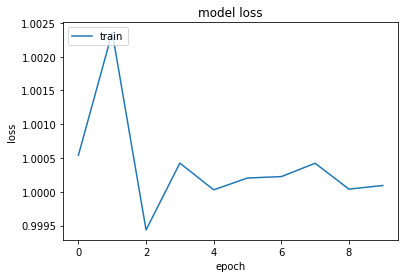

In [316]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Features from **neg** model 

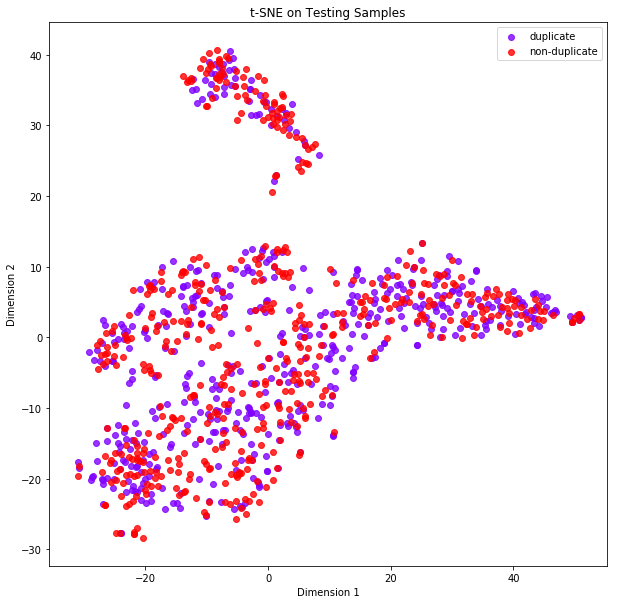

Wall time: 41.1 s


In [267]:
%%time
display_embed_space(similarity_model, 'merge_features_neg', 1024)

Features from **pos** model 

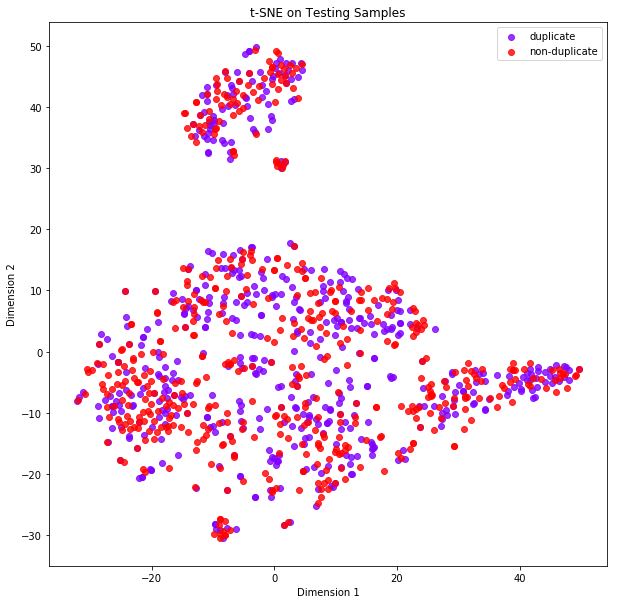

In [266]:
%%time
display_embed_space(similarity_model, 'merge_features_pos', 1024)

Features from **input** model 

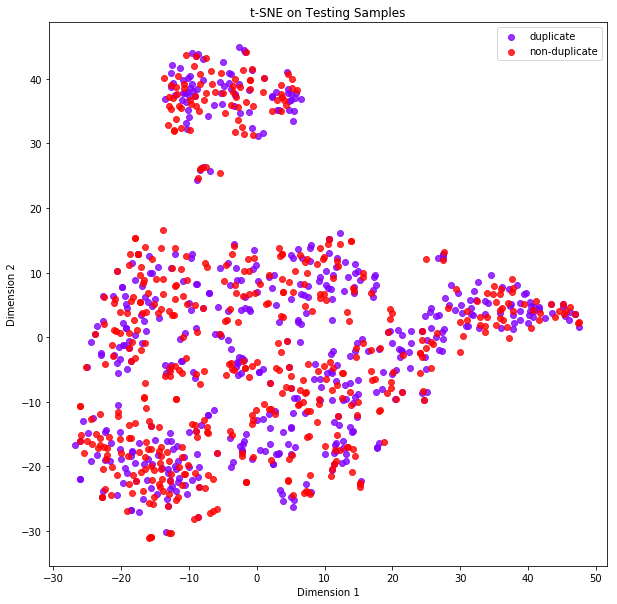

In [254]:
%%time
display_embed_space(similarity_model, 'merge_features_in', 1024)

In [301]:
for layer in similarity_model.layers:
    print(layer.name)

title_in
desc_in
title_pos
desc_pos
title_neg
desc_neg
FeatureLstmGenerationModel
FeatureCNNGenerationModel
merge_features_in
merge_features_pos
merge_features_neg
margin_loss_1


In [321]:
## Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False
    
model_in = similarity_model.get_layer('merge_features_in')
model_pos = similarity_model.get_layer('merge_features_pos')
x_in = model_in.output
x_pos = model_pos.output
x = Concatenate()([x_in, x_pos])
x = Dense(64, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
output = Dense(2, activation = 'softmax', name = 'output')(x)
model_clf = Model(inputs=similarity_model.input, outputs=output)
model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_clf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
FeatureLst

In [ ]:
%%time

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

valid_labels = encoder.fit_transform(test_gen[1])
valid_labels = to_categorical(valid_labels)
test_validation = (test_gen[0], valid_labels)

h_clf = model_clf.fit_generator(siam_gen_classification(bug_dir, 512, 1), 
                               steps_per_epoch = 16,
                                validation_split=0.2,
                               #validation_data=test_validation, # 
                                             epochs = 10,
                                             verbose = True) # callbacks=[early]

Epoch 1/10
16/16 [==============================] - ETA: 3:03 - loss: 0.9303 - acc: 0.500 - ETA: 2:02 - loss: 0.8137 - acc: 0.500 - ETA: 1:38 - loss: 0.7838 - acc: 0.500 - ETA: 1:22 - loss: 0.7683 - acc: 0.500 - ETA: 1:10 - loss: 0.7571 - acc: 0.500 - ETA: 1:01 - loss: 0.7475 - acc: 0.500 - ETA: 54s - loss: 0.7399 - acc: 0.499 - ETA: 46s - loss: 0.7343 - acc: 0.49 - ETA: 39s - loss: 0.7301 - acc: 0.49 - ETA: 33s - loss: 0.7269 - acc: 0.49 - ETA: 27s - loss: 0.7238 - acc: 0.49 - ETA: 21s - loss: 0.7211 - acc: 0.50 - ETA: 16s - loss: 0.7192 - acc: 0.50 - ETA: 10s - loss: 0.7175 - acc: 0.50 - ETA: 5s - loss: 0.7158 - acc: 0.5005 - 90s 6s/step - loss: 0.7145 - acc: 0.4994 - val_loss: 0.6923 - val_acc: 0.5117
Epoch 2/10
16/16 [==============================] - ETA: 1:13 - loss: 0.6938 - acc: 0.498 - ETA: 1:06 - loss: 0.6941 - acc: 0.498 - ETA: 1:01 - loss: 0.6937 - acc: 0.499 - ETA: 56s - loss: 0.6935 - acc: 0.499 - ETA: 51s - loss: 0.6933 - acc: 0.50 - ETA: 47s - loss: 0.6933 - acc: 0.50 -

In [ ]:
validation_accuracy_loss(h_clf)

In [60]:
name = 'baseline_10epoch_16steps_512batch(test)'
save_model(similarity_model, name)
save_result(h, name)

Saved model to disk
